In [1]:
import xarray as xr
from CMIP6_IO import CMIP6_IO
from dask.distributed import Client
from pathlib import Path
import matplotlib.pyplot as plt


## Create ensemble files from running CMIP6_light.py
This script will loop over all files found in a speficic folder `lightpath`and find files of teh same variable and scenario to create ensemble files from. The various variables to create ensembles for include `["uvb_","uv_","uvi_","par_", "uvb_", "uva_"]`.

The output is stored under folder `ensemble_path` and the results are used to create the final plots of modeled lightlyfor the paper using notebooks `CMIP6_plot_light_results.ipynb`.


In [2]:
# Define what models, scenarios, and variables to calculate ensemble files from
tt="CMCC-ESM2"

source_ids = ["CanESM5", "MPI-ESM1-2-LR", "UKESM1-0-LL", "MPI-ESM1-2-HR"]

scenarios = ["ssp245"] #["ssp245", "ssp585"]
var_names = ["par_", "uvb_", "uv_", "uvi_", "uva_", "uv_srf_"]  # ,"_tos.nc","_siconc.nc"]
var_names = ["uv_", "uvi_", "uva_"] 
var_names = ["uvb_"] #, "_tos.nc","_siconc.nc"]
var_names = ["par"] #, "uvi_", "uva_"] #, "_tos.nc","_siconc.nc"]

create_ensemble_files = True
io = CMIP6_IO()

In [3]:
import numpy as np

 
def collect_ds(scenarios, var_names, ds_list):
    max_models=300
    for var_name in var_names:
        for scenario in scenarios:
            counter=0
        
            if var_name not in ["tos"]:
                lightpath = "light/ncfiles_nobias"
            else:
                lightpath = f"light/{scenario}"
             
            current = f"{lightpath}"
            file_on_gcs = io.list_dataset_on_gs(current)
           
            # Loop over all files and filter on the models defined in source_ids.
            for f in file_on_gcs:
                
                # Filter to only use the models we prefer
                if any(model in f for model in source_ids) and f"{var_name}_" in f and "uv_srf" not in f and scenario in f and "rsus" not in f and "rsds" not in f:
                    print(f)
                      
                    if counter >= max_models:
                        pass
                    else:
                        p = Path(f).name
                        model = p.split("_")[1] + "_" + p.split("_")[2]
                        
                        if model: # not in ["MPI-ESM1-2-HR_r1i1p1f1","MPI-ESM1-2-HR_r2i1p1f1"]: 
                            ds = io.open_dataset_on_gs(f)
                            
                            print("=======")
                            print(model)
                        
                            ds_resampled = ds[var_name]
                            ds_list[model] = ds_resampled
                            print("TIME", len(ds_resampled.time.values))
                            print("PERIOD", ds_resampled.time.values[0], ds_resampled.time.values[-1])
                            counter+=1
                        else:
                            print(f"Skipping model {model}")
                            
            # Add the ensemble weighted
            
            if var_name in ["tos"]:
                f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}_weighted.nc"
            else:
                f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}__weighted.nc"
            ds = io.open_dataset_on_gs(f)

            if ds is not None:
                ds = ds.rename({f"{var_name}_mean": f"{var_name}"})
                ds_list["ensemble_weighted"] = ds[var_name]
                if var_name in ["tos"]:
                    f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}.nc"
                else:
                    f = f"{lightpath}/ensemble/CMIP6_ensemble_stats_{scenario}_{var_name}_.nc"
                ds = io.open_dataset_on_gs(f)
                ds = ds.rename({f"{var_name}_mean": f"{var_name}"})
                ds_list["ensemble_unweighted"] = ds[var_name]
            
    return ds_list

ds_list = {}
ds_list = collect_ds(scenarios, var_names, ds_list)
print(ds_list.keys())

light/ncfiles_nobias/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc


/home/tk/.local/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


CanESM5_r10i1p2f1
TIME 8709
PERIOD 1979-01-16T12:00:00.000000000 2099-12-16T20:00:00.000000000
light/ncfiles_nobias/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
CanESM5_r1i1p2f1
TIME 8709
PERIOD 1979-01-16T12:00:00.000000000 2099-12-16T20:00:00.000000000
light/ncfiles_nobias/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
CanESM5_r2i1p2f1
TIME 8709
PERIOD 1979-01-16T12:00:00.000000000 2099-12-16T20:00:00.000000000
light/ncfiles_nobias/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light/ncfiles_nobias/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
CanESM5_r3i1p2f1
TIME 8709
PERIOD 1979-01-

In [4]:
min_lon = 5
max_lon = 35    
min_lat = 69
max_lat = 79
var_name = "par"
scenario  ="ssp245"
if var_name not in ["tos"]:
    lightpath = "light/ncfiles_nobias"
else:
    lightpath = f"light/{scenario}"
            

/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r10i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r1i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r2i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r3i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r7i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting CanESM5_r9i1p2f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting MPI-ESM1-2-HR_r1i1p1f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting MPI-ESM1-2-HR_r2i1p1f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting MPI-ESM1-2-LR_r10i1p1f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting MPI-ESM1-2-LR_r6i1p1f1


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting UKESM1-0-LL_r1i1p1f2


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting UKESM1-0-LL_r2i1p1f2


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


Running calculations and plotting UKESM1-0-LL_r3i1p1f2
Running calculations and plotting UKESM1-0-LL_r4i1p1f2


/home/tk/.local/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


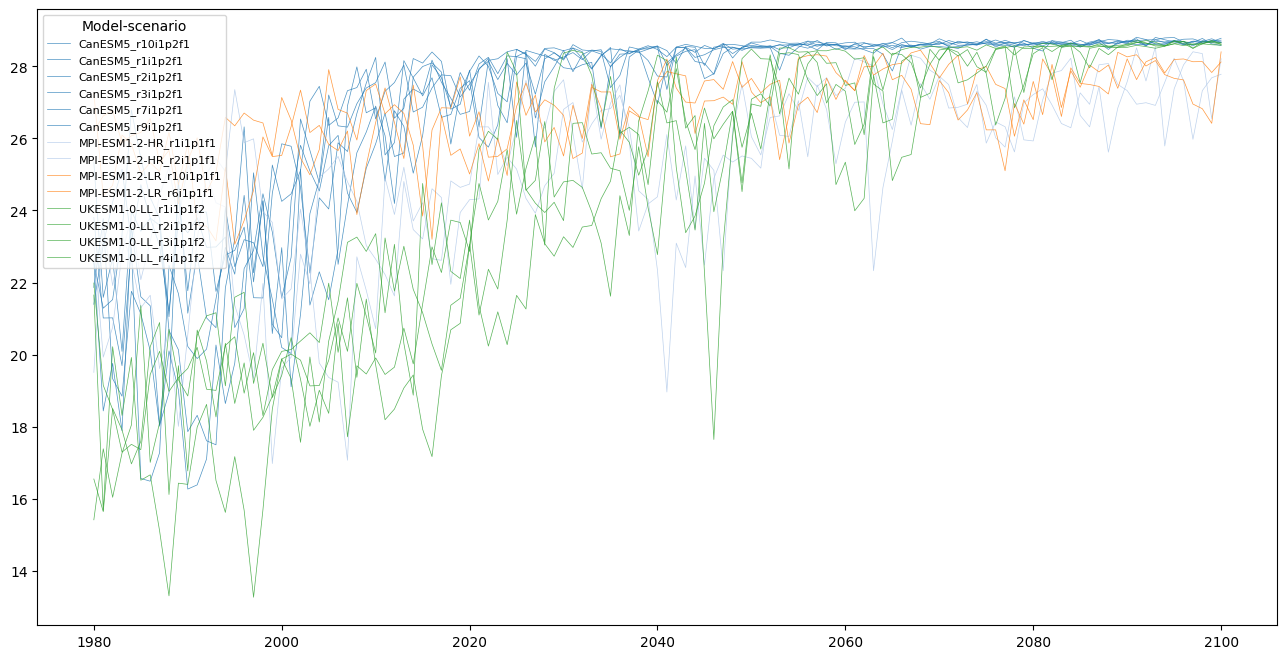

In [5]:
fig, ax = plt.subplots(figsize=(16,8))

saved_model_name = None
color_index=0      
for model in ds_list.keys():
        ds = ds_list[model]
        if var_name in ["tos"]:
                ds = ds.sel(y=slice(min_lat, max_lat), 
                x=slice(min_lon, max_lon)).mean({"y","x"})
        else:   
                ds = ds.sel(lat=slice(min_lat, max_lat), 
                lon=slice(min_lon, max_lon)).mean({"lat","lon"})
        
        ds = ds.resample(time="A").mean(skipna=True)
  
        colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
        model_name = model.split("_")[0]

        if saved_model_name is None or saved_model_name != model_name:
                saved_model_name = model_name
                color=colors[color_index]
                color_index+=1
        linewidth=0.5
        alpha=0.8
        print(f"Running calculations and plotting {model}")        
        
        if model in ["ensemble_weighted"]:
                color="tab:orange"
                linewidth=2.0
                alpha=1.0
        if model in ["ensemble_unweighted"]:
                color="tab:blue"
                linewidth=2.0
                alpha=1.0
        
        ax.plot(ds.time.values,
                ds,
                linewidth=linewidth,
                color=color,
                alpha=alpha,
                label=f"{model}")

ax.legend(title="Model-scenario",fontsize=8, title_fontsize=10, loc='upper left')